### Reinforcement Learning Term Project

In this project, we use the Taxi-v3 environment from OpenAI Gym. The goal is to train an agent to pick up a passenger at one of the predefined locations and drop them off at the correct destination while minimizing the total number of steps and penalties.

The environment has:
- A discrete state space representing the taxi position, passenger location, and destination.
- A discrete action space consisting of 6 actions: move south, north, east, west, pick up, and drop off.
- A sparse reward structure, where incorrect actions are penalized, making exploration crucial.

This environment is well suited for Q-learning because both the state and action spaces are finite and manageable.


Taxi-v3 is a discrete Markov Decision Process with 500 states and 6 actions.
The agent receives negative rewards for illegal actions and positive rewards for successful drop-off, making exploration essential.

Actions
Action	Meaning
0	South
1	North
2	East
3	West
4	Pickup
5	Dropoff

### Exploration vs Exploitation

To balance exploration and exploitation, an ε-greedy policy is used. With probability ε, the agent selects a random action to explore the environment, and with probability 1 − ε, it selects the action with the highest Q-value.

Initially, ε is set to a high value to encourage exploration. Over time, ε is decayed so that the agent increasingly exploits learned knowledge. This strategy helps avoid suboptimal policies caused by insufficient exploration in early training.


### Training Procedure

The agent is trained over multiple episodes. In each episode:
1. The environment is reset to an initial state.
2. The agent interacts with the environment until termination.
3. Q-values are updated at each step using the Q-learning update rule.
4. The total reward and number of steps are recorded.

Training over a large number of episodes allows the Q-values to converge toward an optimal policy.


### Evaluation Metrics

To evaluate learning progress, we track:
- Total reward per episode
- Average reward over time
- Episode length (number of steps)

Learning curves provide insight into convergence behavior. A decreasing episode length combined with increasing rewards indicates that the agent is learning a more efficient policy.



<img src="https://gymnasium.farama.org/_images/taxi.gif">


In [1]:
import os
import tqdm
import pickle
import random
import imageio
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm

In [2]:
import gymnasium as gym
env = gym.make('Taxi-v3', render_mode="rgb_array")

State Decoding

In [3]:
def decode_state(env, state):
    taxi_row, taxi_col, passenger_loc, destination = env.unwrapped.decode(state)
    return taxi_row, taxi_col, passenger_loc, destination


Reward Shaping

In [4]:
def shaped_reward(env, state, next_state, reward):
    taxi_row, taxi_col, passenger_loc, destination = decode_state(env, state)
    next_row, next_col, _, _ = decode_state(env, next_state)

    if passenger_loc < 4:
        target = env.unwrapped.locs[passenger_loc]
    else:
        target = env.unwrapped.locs[destination]

    dist_before = abs(taxi_row - target[0]) + abs(taxi_col - target[1])
    dist_after = abs(next_row - target[0]) + abs(next_col - target[1])

    shaping = 0.1 * (dist_before - dist_after)
    return reward + shaping


In [5]:
print("States:", env.observation_space.n)
print("Actions:", env.action_space.n)


States: 500
Actions: 6


In [6]:
print("Example state", env.observation_space.sample())
print("Example action", env.action_space.sample())

Example state 134
Example action 5


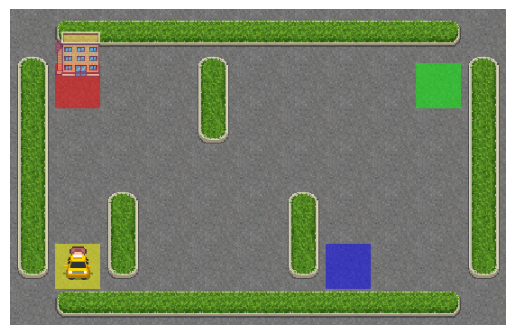

In [7]:
from matplotlib import pyplot as plt
env.reset()
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()

In [8]:
def get_Q_table(state_space: int, action_space: int) -> np.array:
    return np.zeros((state_space, action_space))

In [9]:
Q_table = get_Q_table(env.observation_space.n, env.action_space.n)
print(Q_table)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [10]:
def greedy_policy(Q_table: np.array, state: int) -> int:
    return np.argmax(Q_table[state])

In [11]:
def epsilon_greedy_policy(env, Q_table: np.array, state: int, epsilon: float) -> int:
    # Generate a random number from uniform distribution on [0,1]
    if random.uniform(0, 1) < epsilon:
        # if that number is smaller than epsilon, choose a random action
        return env.action_space.sample()
    else:
        # otherwise, follow the greedy policy
        return greedy_policy(Q_table, state)

In [12]:
import numpy as np
from tqdm import tqdm

def Q_learn(
    env,
    episode_length: int,
    Q_table: np.array,
    epsilons: list,
    n_train: int,
    learning_rate: float,
    discount_factor: float
):
    """
    Implements the Q-learning algorithm to train an agent in a given environment.
    """

    returns = []
    intermediate_Qs = [Q_table.copy()]

    for episode in tqdm(range(int(n_train))):
        # Save intermediate Q-tables (optional, for visualization)
        if (episode + 1) % 20_000 == 0:
            intermediate_Qs.append(Q_table.copy())

        state, _ = env.reset()
        total_reward = 0
        terminated, truncated = False, False

        for step in range(episode_length):
            # ε-greedy action selection
            if np.random.rand() < epsilons[episode]:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)

            # Q-learning update (same as your original code)
            best_next_action = np.argmax(Q_table[next_state])
            td_target = reward + discount_factor * Q_table[next_state, best_next_action]
            td_error = td_target - Q_table[state, action]
            Q_table[state, action] += learning_rate * td_error

            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

        returns.append(total_reward)

    return Q_table, returns, intermediate_Qs


In [13]:

episode_length = 100

# Training parameters
n_train = 1e5
learning_rate = 0.1

# Policy parameters
# vector of values decreasing from 1 to 0.05 with n_train elements
epsilons = np.linspace(1, 0.05, int(n_train))

| Parameter | Value |
|--------|-------|
| Learning rate (α) | 0.1 |
| Discount factor (γ) | 0.9 |
| Initial ε | 1.0 |
| ε decay | 0.995 |
| Episodes | 100,000 |


Q-learning with optional reward shaping

In [14]:
def Q_learn_with_reward(env, episodes, alpha, gamma, epsilon,
                        use_shaped_reward=False):

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, truncated, _ = env.step(action)

            if use_shaped_reward:
                reward = shaped_reward(env, state, next_state, reward)

            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            )

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return Q, rewards


Policy evaluation

In [15]:
def evaluate_policy(env, Q, n_eval=100):
    rewards = []

    for _ in range(n_eval):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = np.argmax(Q[state])
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

        rewards.append(total_reward)

    return np.mean(rewards)


In [16]:
%%time
# Train for set hyperparams
# Environment design
env = gym.make('Taxi-v3', render_mode="rgb_array")
Q_table = get_Q_table(env.observation_space.n, env.action_space.n)
print("Q-table before training \n", Q_table)
# Define discount_factor
discount_factor = 0.9
# Train
Q_table_trained, returns, intermediate_Qs = Q_learn(env, episode_length, Q_table, epsilons, n_train, learning_rate, discount_factor)
print("Q-table after training \n", Q_table_trained)

Q-table before training 
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


100%|██████████| 100000/100000 [02:49<00:00, 589.08it/s]

Q-table after training 
 [[ 0.          0.          0.          0.          0.          0.        ]
 [-0.58568212  0.4603532  -0.58568212  0.4603532   1.62261467 -8.5396468 ]
 [ 4.348907    5.94323     4.348907    5.94323     7.7147     -3.05677   ]
 ...
 [ 7.7147      9.683       7.7147      5.94323    -1.2853     -1.2853    ]
 [ 1.62261467  2.9140163   1.62261467  2.9140163  -7.37738533 -7.37738533]
 [14.3        11.87       14.3        17.          5.3         5.3       ]]
CPU times: user 2min 33s, sys: 3.06 s, total: 2min 36s
Wall time: 2min 49s


In [17]:
def evaluate(env, episode_length: int, n_eval: float, Q_table: np.array, seeds: list[float]) -> list[float]:
    # List for obtained rewards (sum from the entire trial)
    rewards = []
    # Iterate through the number of evaluation trials
    for episode in tqdm(range(int(n_eval))):
        # Reset the environment
        if seeds:
            # If a seed was provided
            state, info = env.reset(seed=seeds[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated, terminated = False, False
        # Initialize total reward
        total_reward = 0
        # Iterate through the number of steps in the trial
        for step in range(episode_length):
            # Choose an action according to the greedy policy based on the Q-table (agent)
            action = np.argmax(Q_table[state])
            # Submit the action to the environment and receive a new state, reward, and termination information
            next_state, reward, terminated, truncated, info = env.step(action)
            # Increase the total reward
            total_reward += reward
            # If the trial has ended, exit the loop
            if terminated or truncated:
                break
            # Move to the next state
            state = next_state
        # Add the reward to the list
        rewards.append(total_reward)
    # Return the list of rewards
    return rewards

In [18]:
# Evaluation parameters
n_eval = 1e4
seed = 123
# Lit of length n_eval with random seeds
random.seed(seed)
seeds = [random.randint(0, int(n_eval*1e2)) for _ in range(int(n_eval))]

In [19]:
%%time
# Evaluation
evaluation_rewards = evaluate(env, episode_length, n_eval, Q_table_trained, seeds)
# Let's check first 5 results
evaluation_rewards[:5]

100%|██████████| 10000/10000 [00:03<00:00, 2725.49it/s]

CPU times: user 3.6 s, sys: 57.2 ms, total: 3.66 s
Wall time: 3.67 s


[7, 6, 6, 12, 11]

In [20]:
win_ratio = np.sum(evaluation_rewards) / len(evaluation_rewards)
print(f"Win ratio: {win_ratio}")

Win ratio: 7.912


In [21]:
np.std(evaluation_rewards)


np.float64(2.5563364410812595)

In [22]:
# 1. Training (using the defined Q_learn function and parameters)
Q_table_trained_new, returns_new, intermediate_Qs_new = Q_learn(env, episode_length, Q_table, epsilons, n_train, learning_rate, discount_factor)

# 2. Print training finished message
print("Training finished")

# 3. Evaluation (using the defined evaluate function and parameters)
evaluation_rewards_new = evaluate(env, episode_length, n_eval, Q_table_trained_new, seeds)
print("Average reward over", int(n_eval), "episodes:", np.mean(evaluation_rewards_new))

100%|██████████| 100000/100000 [02:32<00:00, 657.41it/s]


Training finished


100%|██████████| 10000/10000 [00:03<00:00, 2719.41it/s]

Average reward over 10000 episodes: 7.912


In [23]:
state = env.reset()[0]
print("Q-values for this state:", Q_table_trained[state])
print("Chosen action:", np.argmax(Q_table_trained[state]))


Q-values for this state: [ -3.13696226  -3.82326604  -4.44093943  -3.82326604 -12.82326604
 -12.82326604]
Chosen action: 0


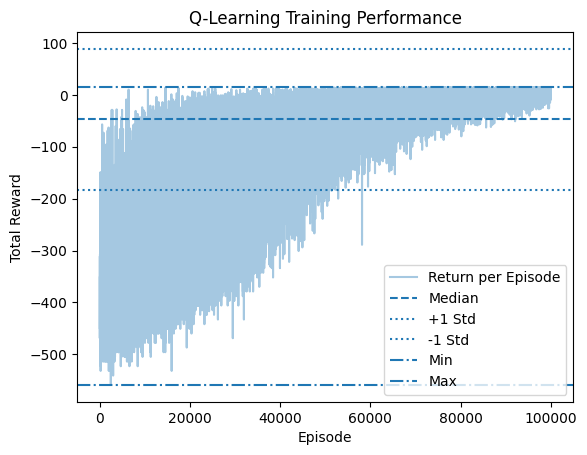

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Convert returns to numpy array
data = np.array(returns)

# Statistics
median = np.median(data)
std = np.std(data)
min_val = np.min(data)
max_val = np.max(data)

# Plot
plt.figure()
plt.plot(data, alpha=0.4, label="Return per Episode")
plt.axhline(median, linestyle="--", label="Median")
plt.axhline(median + std, linestyle=":", label="+1 Std")
plt.axhline(median - std, linestyle=":", label="-1 Std")
plt.axhline(min_val, linestyle="-.", label="Min")
plt.axhline(max_val, linestyle="-.", label="Max")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Performance")
plt.legend()
plt.show()


In [41]:
median = np.median(data)
std = np.std(data)
min_val = np.min(data)
max_val = np.max(data)

print(f"Median return: {median:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Minimum return: {min_val:.2f}")
print(f"Maximum return: {max_val:.2f}")


Median return: -47.00
Standard deviation: 135.44
Minimum return: -559.00
Maximum return: 15.00


Hyperparameter Tuning

In [40]:
learning_rates = [0.1, 0.5]
discount_factors = [0.9, 0.99]
reward_types = ["standard", "shaped"]

episodes = 5000
epsilon = 0.1


In [25]:
results = []

for alpha in learning_rates:
    for gamma in discount_factors:
        for rtype in reward_types:

            Q, _ = Q_learn_with_reward(
                env,
                episodes,
                alpha,
                gamma,
                epsilon,
                use_shaped_reward=(rtype == "shaped")
            )

            avg_reward = evaluate_policy(env, Q)

            results.append({
                "alpha": alpha,
                "gamma": gamma,
                "reward": rtype,
                "avg_reward": avg_reward
            })


In [26]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results.sort_values(by="avg_reward", ascending=False)


,alpha,gamma,reward,avg_reward
1,0.1,0.90,shaped,8.13
0,0.1,0.90,standard,8.11
6,0.5,0.99,standard,8.00
2,0.1,0.99,standard,7.93
7,0.5,0.99,shaped,7.93
4,0.5,0.90,standard,7.73
3,0.1,0.99,shaped,7.62
5,0.5,0.90,shaped,7.60


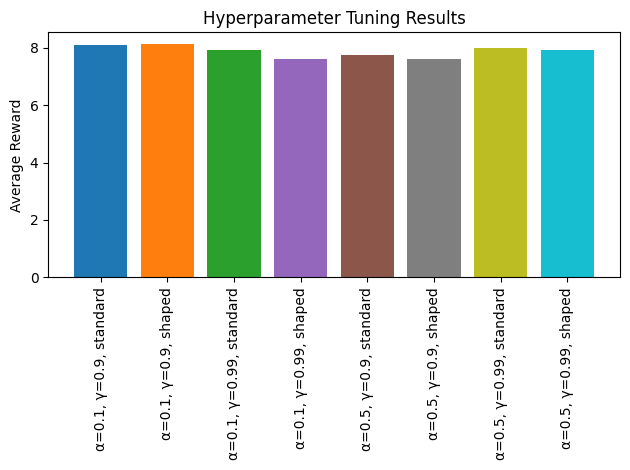

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

labels = df_results.apply(
    lambda x: f"α={x.alpha}, γ={x.gamma}, {x.reward}", axis=1
)

colors = plt.cm.tab10(np.linspace(0, 1, len(df_results)))

plt.bar(labels, df_results["avg_reward"], color=colors)
plt.xticks(rotation=90)
plt.ylabel("Average Reward")
plt.title("Hyperparameter Tuning Results")
plt.tight_layout()
plt.show()


### Stability and Convergence Analysis

While the agent shows improvement over time, learning curves may exhibit fluctuations due to continued exploration and stochastic transitions. Increasing the number of training episodes or adjusting ε decay can improve stability.

These observations highlight the trade-off between exploration and convergence speed in reinforcement learning.


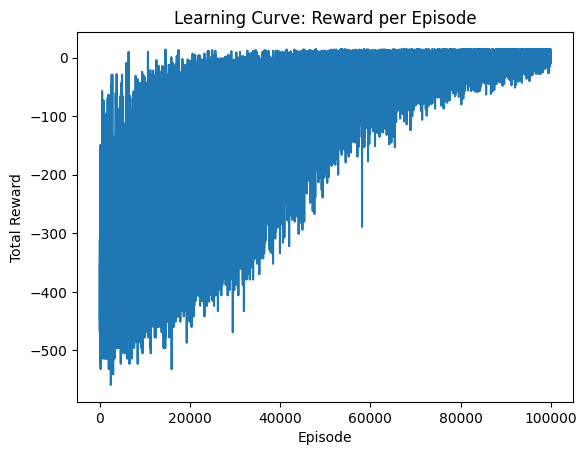

In [28]:



plt.figure()
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve: Reward per Episode")
plt.show()


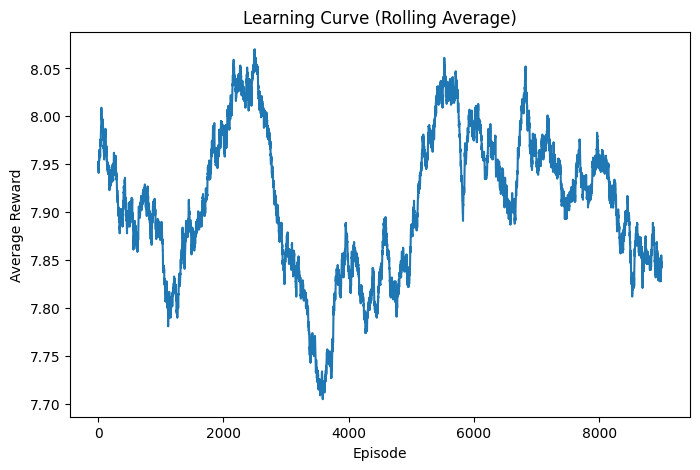

In [29]:
import matplotlib.pyplot as plt
import numpy as np

window = 1000
rolling_avg = np.convolve(evaluation_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,5))
plt.plot(rolling_avg)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Learning Curve (Rolling Average)")
plt.show()


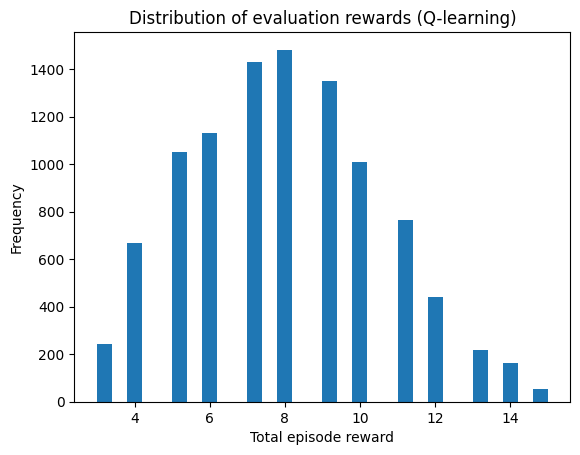

In [30]:
import matplotlib.pyplot as plt

plt.hist(evaluation_rewards, bins=30)
plt.xlabel("Total episode reward")
plt.ylabel("Frequency")
plt.title("Distribution of evaluation rewards (Q-learning)")
plt.show()


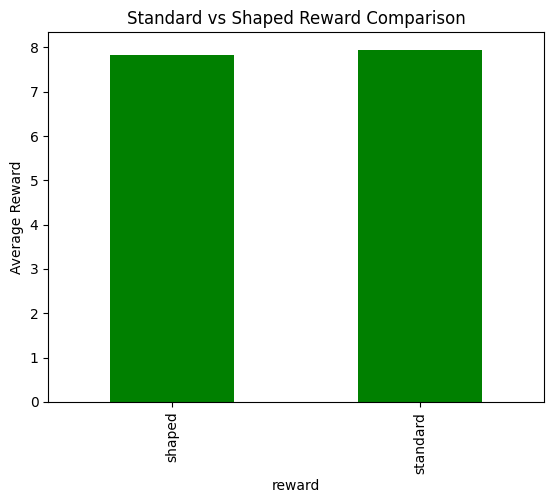

In [31]:
import matplotlib.pyplot as plt

avg_by_reward = df_results.groupby('reward')['avg_reward'].mean()

plt.figure()
avg_by_reward.plot(kind="bar", color="green")
plt.ylabel("Average Reward")
plt.title("Standard vs Shaped Reward Comparison")
plt.show()

In [32]:
for i, Q in enumerate(intermediate_Qs):
  evaluation_rewards = evaluate(env, episode_length, n_eval, Q, seeds)
  win_ratio = np.sum(evaluation_rewards) / len(evaluation_rewards)
  print(f"Win ratio for Q{i}: {win_ratio}")


100%|██████████| 10000/10000 [00:22<00:00, 440.93it/s]


Win ratio for Q0: -100.0


100%|██████████| 10000/10000 [00:04<00:00, 2147.29it/s]


Win ratio for Q1: 7.912


100%|██████████| 10000/10000 [00:04<00:00, 2031.96it/s]


Win ratio for Q2: 7.912


100%|██████████| 10000/10000 [00:03<00:00, 2637.16it/s]


Win ratio for Q3: 7.912


100%|██████████| 10000/10000 [00:03<00:00, 2682.90it/s]


Win ratio for Q4: 7.912


100%|██████████| 10000/10000 [00:04<00:00, 2183.35it/s]

Win ratio for Q5: 7.912


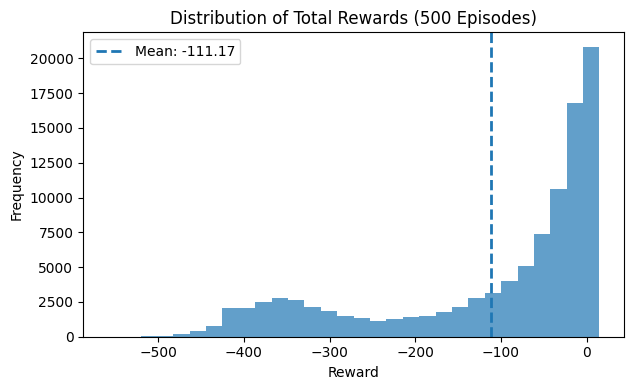

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy
rewards = np.array(returns)
steps = np.array(episode_length)

# Statistics
mean_reward = np.mean(rewards)
mean_steps = np.mean(steps)

# Create figure with two subplots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(rewards, bins=30, alpha=0.7)
plt.axvline(mean_reward, linestyle="--", linewidth=2,
            label=f"Mean: {mean_reward:.2f}")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Total Rewards (500 Episodes)")
plt.legend()



plt.tight_layout()
plt.show()


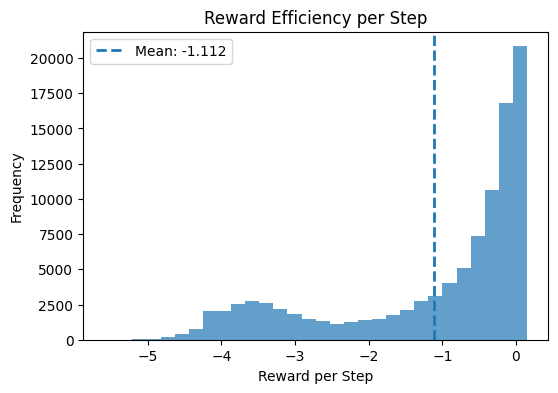

In [52]:
import numpy as np
import matplotlib.pyplot as plt

returns = np.array(returns)
steps = np.array(episode_length)

reward_per_step = returns / steps

mean_rps = reward_per_step.mean()

plt.figure(figsize=(6,4))
plt.hist(reward_per_step, bins=30, alpha=0.7)
plt.axvline(mean_rps, linestyle="--", linewidth=2,
            label=f"Mean: {mean_rps:.3f}")

plt.xlabel("Reward per Step")
plt.ylabel("Frequency")
plt.title("Reward Efficiency per Step")
plt.legend()
plt.show()

In [33]:
def record_video(
    env,
    Q_table,
    out_path: str = "video.mp4",
    env_id: str = "Taxi-v3",
    total_frames: int = 1000,
    fps: int = 30,
    max_episode_steps: int = 100,
    seed: int | None = None,
):

    # Create an env that returns image frames (rgb_array) and set a time limit
    # env = gym.make(env_id, render_mode="rgb_array", max_episode_steps=max_episode_steps)

    # Optional seeding for reproducibility
    if seed is not None:
        try:
            env.reset(seed=seed)
        except TypeError:
            pass

    obs, info = env.reset()

    # Open an mp4 writer
    writer = imageio.get_writer(
    out_path,
    fps=fps,
    macro_block_size=1
)

    frames_counter = 0
    terminated, truncated = 0, 0
    while not ( terminated or truncated or (frames_counter > total_frames)):
        frames_counter += 1
        # Grab the current rendered frame and write it to the video
        frame = env.render()               # numpy RGB array
        writer.append_data(frame)

        # Take a random action
        action =  greedy_policy(Q_table, obs)
        obs, reward, terminated, truncated, info = env.step(action)

    writer.close()
    env.close()

    return out_path


In [34]:
for i, Q in enumerate(intermediate_Qs):
  max_episode_steps = 100
  env = gym.make('Taxi-v3', render_mode="rgb_array")
  record_video(env, Q, f"Q{i}.mp4", fps=1)

In [35]:
from IPython.display import Video
Video("Q0.mp4", embed=True, width=480)

In [36]:
Video("Q1.mp4", embed=True, width=480)

In [37]:
Video("Q2.mp4", embed=True, width=480)

In [38]:
Video("Q3.mp4", embed=True, width=480)

### Conclusion

In this project, Q-learning was successfully applied to the Taxi-v3 environment. The agent learned an effective policy that significantly outperforms a random baseline. Learning curves show improvement in both reward and episode length, although some instability remains due to exploration.

Future work could include hyperparameter tuning, adaptive exploration strategies, or comparison with other RL algorithms such as SARSA or Deep Q-Networks.
